In [2]:
%load_ext autoreload
%autoreload 2


import dynamiqs as dq
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from utils import (
    MHz,
    expected_parity,
    fit_experimental_data,
    fit_function_zeno_calib,
    get_drive_amp,
    get_eps_X_from_expects,
    get_opt_amp_gate,
    get_opt_eps_X,
    get_t_gate,
    kHz,
    ns,
    optimal_gates,
    simulate_zeno,
    us,
)

# One Zeno Simulation

In [3]:
params = dict(
    N0=150,
    N1=20,
    lam=0.0,
    alpha=jnp.sqrt(4),
    kappa_2=0.4 * MHz,
    kappa_a=1 / (15 * us),
    kappa_phi=1 / (10 * us),
    nth=0,
    kerr=0.0 * kHz,
    amp_gate=0 * ns,
    Nt=101,
    rho_0=2,
    save_states=True,
)

In [4]:
output = simulate_zeno(**params)

|██████████| 100.0% ◆ elapsed 32.80ms ◆ remaining 0.00ms


100%|██████████| 50/50 [00:04<00:00, 11.99it/s]


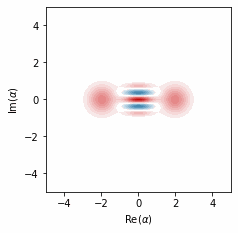

In [6]:
dq.plot.wigner_gif(output.states)

/tmp/ipykernel_410628/797335629.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  a.legend()


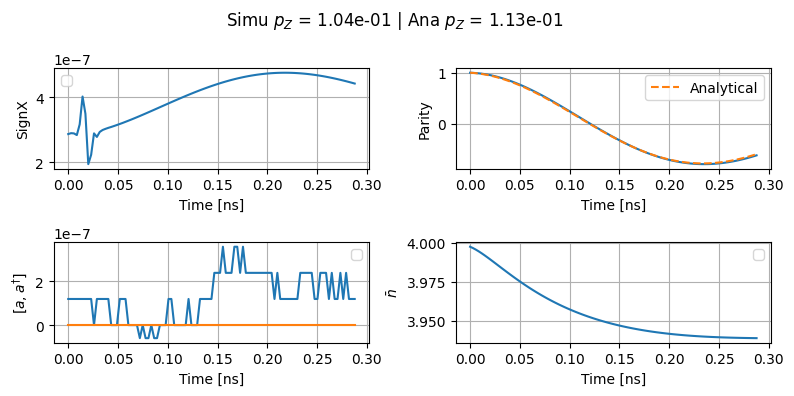

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(8, 4))
for a, exp, label in zip(
    ax.flatten(), output.expects, ["SignX", "Parity", "$[a, a^\\dag]$", "$\\bar{n}$"]
):
    if label == "$[a, a^\\dag]$":
        a.plot(output.tsave, exp.real - 1)
        a.plot(output.tsave, exp.imag)
    else:
        a.plot(output.tsave, exp.real)
    a.set_xlabel("Time [ns]")
    a.set_ylabel(label)
    a.legend()
    a.grid()
ax[0, 1].plot(
    output.tsave,
    expected_parity(**params, times=output.tsave),
    "--",
    label="Analytical",
)
ax[0, 1].legend()
fig.suptitle(
    f"Simu $p_Z$ = {get_eps_X_from_expects(output.expects[1]):.2e}"
    f" | Ana $p_Z$ = {get_opt_eps_X(**params):.2e}"
)
fig.tight_layout()

# 2D simulation to check the optimal T_gate

In [8]:
params = dict(
    N0=150,
    N1=20,
    lam=0.0,
    alpha=jnp.sqrt(4),
    kappa_2=0.385 * MHz,
    kappa_a=1 / (20 * us),
    kappa_phi=1 / (10 * us),
    nth=0,
    kerr=15.0 * kHz,
    tsave=None,
    Nt=101,
    rho_0=2,
    save_states=False,
)
amp_gate_opt = get_opt_amp_gate(
    params["alpha"], params["lam"], params["kappa_a"], params["kappa_2"], params["nth"]
)
params["tsave"] = np.linspace(0, 5 * get_t_gate(amp_gate_opt, params["alpha"]), 1001)
relative_amps = np.linspace(0.5, 2.0, 101)
amp_gates = relative_amps * amp_gate_opt
outputs = jax.vmap(simulate_zeno, in_axes=(None,) * 9 + (0, None, None, None))(
    params["N0"],
    params["N1"],
    params["alpha"],
    params["lam"],
    params["kappa_2"],
    params["kappa_a"],
    params["kappa_phi"],
    params["nth"],
    params["kerr"],
    amp_gates,
    params["tsave"],
    params["Nt"],
    params["rho_0"],
)

|██████████| 100.0% ◆ elapsed 225.20ms ◆ remaining 0.00ms  


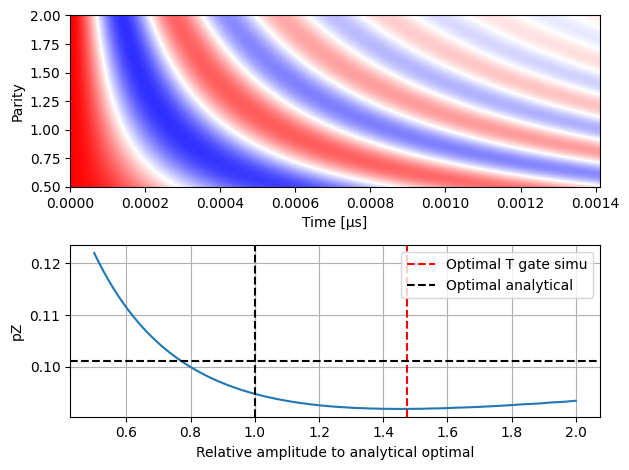

In [9]:
fig, (ax, ax_pZ) = plt.subplots(2)
ax.imshow(
    outputs.expects[:, 1].real,
    aspect="auto",
    origin="lower",
    extent=[
        params["tsave"][0],
        params["tsave"][1],
        relative_amps[0],
        relative_amps[-1],
    ],
    cmap="bwr",
    vmin=-1.0,
    vmax=1.0,
)
ax.set_xlabel("Time [µs]")
ax.set_ylabel("Parity")
pZs = get_eps_X_from_expects(outputs.expects[:, 1])
ax_pZ.plot(relative_amps, pZs)
ax_pZ.set_xlabel("Relative amplitude to analytical optimal")
ax_pZ.set_ylabel("pZ")
ax_pZ.grid(True)
ax_pZ.axvline(
    relative_amps[jnp.argmin(pZs)],
    color="r",
    linestyle="--",
    label="Optimal T gate simu",
)
ax_pZ.axhline(
    get_opt_eps_X(**params), color="k", linestyle="--", label="Optimal analytical"
)
ax_pZ.set_xlim(*ax_pZ.get_xlim())
ax_pZ.axvline(1, color="k", linestyle="--")
ax_pZ.legend()
fig.tight_layout()
plt.show()

## Fitting experimental data

In [8]:
data_dict = np.load("zeno_data_3_photons_0_lam.npy", allow_pickle=True).item()
dc = 4965766191.0
amps, times = (
    jnp.asarray(data_dict["amps"]) * dc * 1e-6,
    jnp.asarray(data_dict["times"]) * ns,
)
guess = jnp.array(
    [
        0.385 * MHz,  # data_dict["kappa_2_fit"],
        10 * kHz,  # data_dict["kappa_1_fit"],
        -data_dict["popt"][0][0],
        data_dict["popt"][0][-1],
    ]
)
res = fit_experimental_data(
    data_dict["alpha"],
    data_dict["lam"],
    times,
    amps,
    jnp.asarray(data_dict["data"]),
    guess,
)
fit = fit_function_zeno_calib(res.x, data_dict["alpha"], data_dict["lam"], times, amps)
print(res)

amps_fit = jnp.linspace(amps[0], amps[-1], 501)
times_fit = jnp.linspace(times[0], times[-1], 5001)
fit_resolved = fit_function_zeno_calib(
    res.x, data_dict["alpha"], data_dict["lam"], times_fit, amps_fit
)
ind_opt = np.argmin((fit_resolved - res.x[-1]) / res.x[-2])
ind_amp, ind_time = np.unravel_index([ind_opt], fit_resolved.shape)
amp_opt = amps_fit[ind_amp]
time_opt = times_fit[ind_time]

|██████████| 100.0% ◆ total 0.34s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.33s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.33s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.33s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.33s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.32s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.32s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.32s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.32s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.32s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.30s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.30s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.30s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.30s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.30s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.29s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.30s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.30s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.30s ◆ remaining 00:00
|██████████|

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 4.085e-11  1.370e-12 ...  1.735e-10  2.517e-10]
           x: [ 2.191e+00  9.906e-02 -8.141e-05  1.035e-04]
        cost: 1.0809637603873593e-17
         jac: [[ 0.000e+00  0.000e+00 -3.580e-04  3.325e-04]
               [ 0.000e+00  7.354e-11 -3.123e-04  3.476e-04]
               ...
               [-9.373e-12  2.498e-10  1.581e-07  3.189e-04]
               [ 3.357e-11 -3.096e-10 -3.400e-07  3.770e-04]]
        grad: [ 7.050e-19 -8.081e-18 -2.741e-12  2.108e-11]
  optimality: 2.1077300446496144e-11
 active_mask: [0 0 0 0]
        nfev: 26
        njev: 3


|██████████| 100.0% ◆ total 0.56s ◆ remaining 00:00


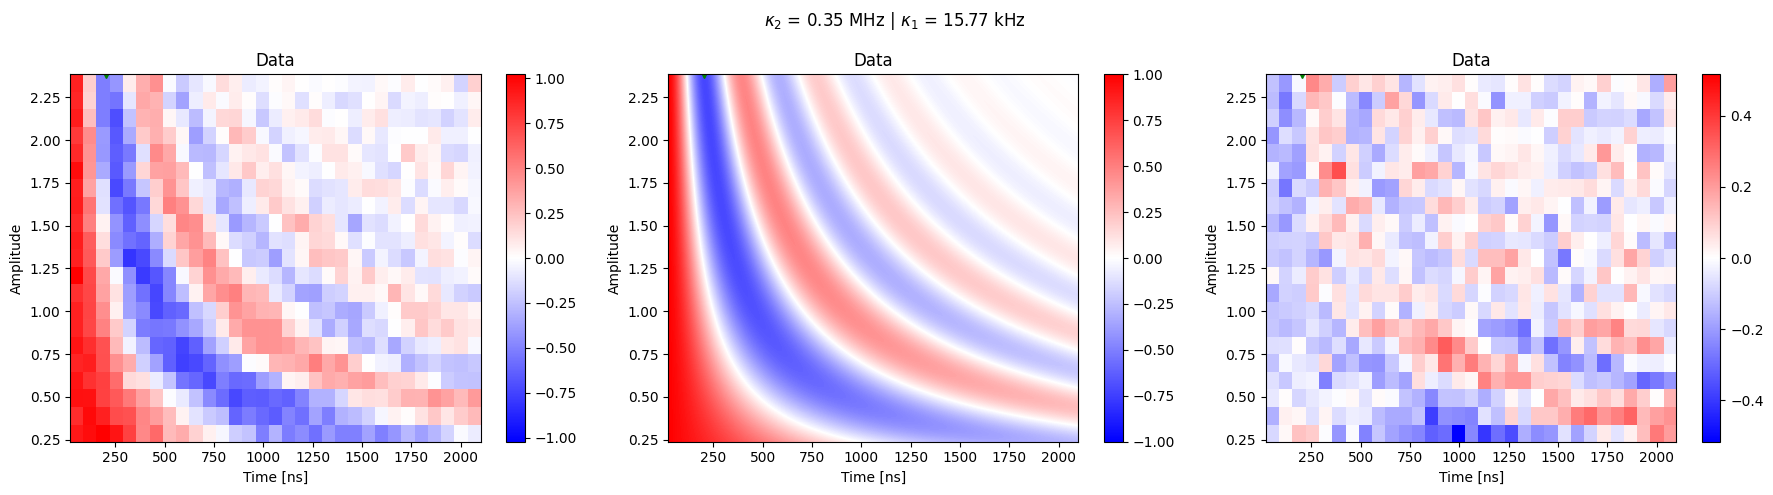

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
for ind, (a, d) in enumerate(
    zip(ax, [data_dict["data"], fit_resolved, data_dict["data"] - fit])
):
    corr = (d - res.x[-1]) / res.x[-2] if ind != 2 else d / res.x[-2]
    extr = np.max(np.abs(corr))
    kwargs = {"cmap": "bwr", "vmin": -extr, "vmax": extr}
    im = a.imshow(
        corr,
        aspect="auto",
        origin="lower",
        extent=[
            data_dict["times"][0],
            data_dict["times"][-1],
            amps[0],
            amps[-1],
        ],
        **kwargs,
    )
    fig.colorbar(im)
    a.set_xlabel("Time [ns]")
    a.set_ylabel("Amplitude")
    a.set_title("Data")
    a.plot(time_opt / ns, amp_opt, "gv")
fig.suptitle(
    rf"$\kappa_2$ = {res.x[0]/MHz:.2f} MHz | $\kappa_1$ = {res.x[1]/kHz:.2f} kHz"
)
fig.tight_layout()
plt.show()

## Fitting all datas

In [103]:
all_datas = np.load("all_zeno_data_for_fit.npy", allow_pickle=True).item()
alphas = jnp.sqrt(all_datas["nbars"])
amps, times = (
    jnp.asarray(all_datas["amps"]) * 1e-6,
    jnp.asarray(all_datas["times"]) * ns,
)
guess = jnp.array([0.385 * MHz, 10 * kHz, 0 * ns, -8e-5, 1e-4])

In [108]:
n_lam, n_nbar = all_datas["nbars"].shape
popts = np.zeros((n_lam, n_nbar, len(guess)))
amps_opt = np.zeros((n_lam, n_nbar))
times_opt = np.zeros((n_lam, n_nbar))
for ind_lam in tqdm(range(n_lam)):
    for ind_nbar in tqdm(range(n_nbar)):
        alpha, lam = alphas[ind_lam, ind_nbar], all_datas["lams"][ind_lam]
        tms, ams = times[ind_lam, ind_nbar], amps[ind_lam, ind_nbar]

        res = fit_experimental_data(
            alpha,
            lam,
            tms,
            ams,
            all_datas["signal"][ind_lam, ind_nbar],
            guess,
        )
        popts[ind_lam, ind_nbar] = res.x
        amps_fit = jnp.linspace(ams[0], ams[-1], 501)
        times_fit = jnp.linspace(tms[0], tms[-1], 5001)
        fit_resolved = fit_function_zeno_calib(res.x, alpha, lam, times_fit, amps_fit)
        ind_opt = np.argmin((fit_resolved - res.x[-1]) / res.x[-2])
        ind_amp, ind_time = np.unravel_index(ind_opt, fit_resolved.shape)
        amps_opt[ind_lam, ind_nbar] = amps_fit[ind_amp]
        times_opt[ind_lam, ind_nbar] = times_fit[ind_time]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [111]:
np.save("popts_zeno_quantum.ipynb", popts)

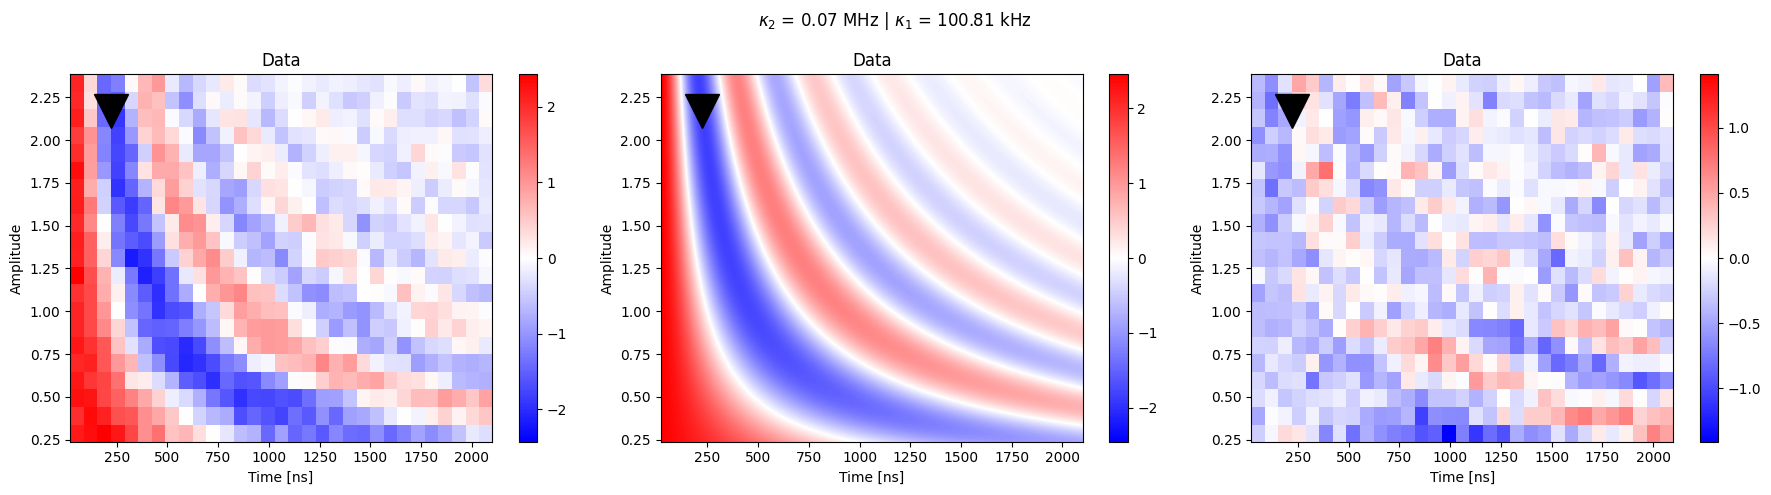

In [125]:
ind_lam, ind_nbar = 0, 0

popt = popts[ind_lam, ind_nbar]
alpha, lam = alphas[ind_lam, ind_nbar], all_datas["lams"][ind_lam]
tms, ams = times[ind_lam, ind_nbar], amps[ind_lam, ind_nbar]

fit = fit_function_zeno_calib(popt, alpha, lam, tms, ams)
amps_fit = jnp.linspace(ams[0], ams[-1], 501)
times_fit = jnp.linspace(tms[0], tms[-1], 5001)
fit_resolved = fit_function_zeno_calib(popt, alpha, lam, times_fit, amps_fit)
s = all_datas["signal"][ind_lam, ind_nbar]
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
for ind, (a, d) in enumerate(zip(ax, [s, fit_resolved, s - fit])):
    corr = (d - res.x[-1]) / res.x[-2] if ind != 2 else d / res.x[-2]
    extr = np.max(np.abs(corr))
    kwargs = {"cmap": "bwr", "vmin": -extr, "vmax": extr}
    im = a.imshow(
        corr,
        aspect="auto",
        origin="lower",
        extent=[tms[0] / ns, tms[-1] / ns, ams[0], ams[-1]],
        **kwargs,
    )
    fig.colorbar(im)
    a.set_xlabel("Time [ns]")
    a.set_ylabel("Amplitude")
    a.set_title("Data")
    a.plot(
        times_opt[ind_lam, ind_nbar] / ns,
        amps_opt[ind_lam, ind_nbar],
        "kv",
        markersize=25,
    )
fig.suptitle(
    rf"$\kappa_2$ = {res.x[0]/MHz:.2f} MHz | $\kappa_1$ = {res.x[1]/kHz:.2f} kHz"
)
fig.tight_layout()
plt.show()

# 4D simulation to extract optimal gate

In [10]:
params = dict(
    N0=150,
    N1=20,
    kappa_2=1 * MHz,
    kappa_a=4 * kHz,  # 1 / (100 * us),
    kappa_phi=1 / (10 * us),
    nth=0.9,
    kerr=15.0 * kHz,
    Nt=2001,
    tsave=None,
    rho_0=2,
    save_states=False,
)

In [11]:
lambdas = jnp.linspace(0, 1, 3)
alphas = jnp.sqrt(jnp.linspace(2, 10, 9))
relative_durations = jnp.geomspace(0.5, 5, 201)
pZ_opt, nbars, amp_opts = optimal_gates(
    lambdas, alphas, relative_durations, params, 2000
)

3 batches. 5427 simulations total.


|██████████| 100.0% ◆ elapsed 4.01s ◆ remaining 0.00ms   


1/3 | elapsed time = 0:00:10 | time per batch = 0:00:10 | time to end = 0:00:20


|██████████| 100.0% ◆ elapsed 2.61s ◆ remaining 0.00ms  


2/3 | elapsed time = 0:00:14 | time per batch = 0:00:07 | time to end = 0:00:07


|██████████| 100.0% ◆ elapsed 1.83s ◆ remaining 0.00ms  


3/3 | elapsed time = 0:00:18 | time per batch = 0:00:06 | time to end = 0:00:00


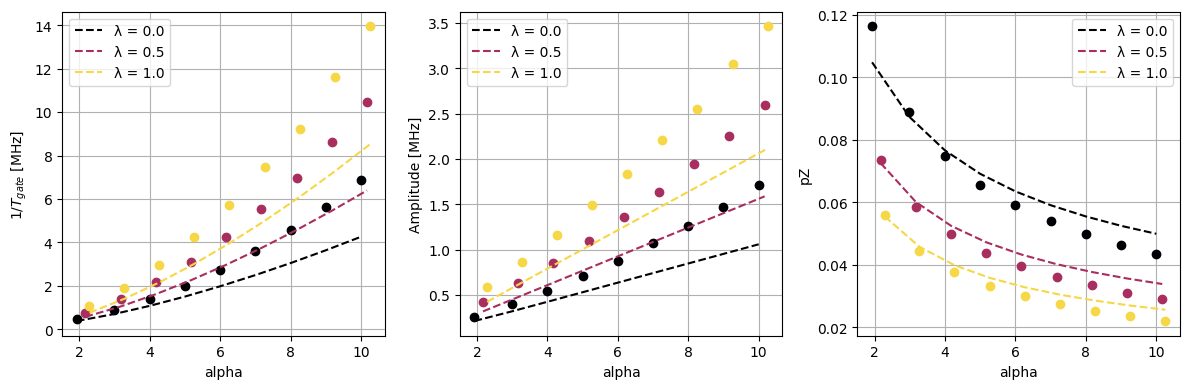

In [12]:
lambdas_map, alphas_map = jnp.meshgrid(lambdas, alphas, indexing="ij")

t_gates_opt = get_t_gate(amp_opts, alphas_map)
ana_amp = get_opt_amp_gate(
    alphas_map, lambdas_map, params["kappa_a"], params["kappa_2"], params["nth"]
)
ana_t_gate = get_t_gate(ana_amp, alphas_map)
ana_pZ = get_opt_eps_X(alphas_map, lambdas_map, **params)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
colors = plt.get_cmap("inferno")(jnp.linspace(0, 0.9, lambdas.size))
for a, d, ylabel, f in zip(
    ax,
    [1 / (t_gates_opt / us) / 2 / jnp.pi, amp_opts / MHz, pZ_opt],
    ["$1/T_{gate}$ [MHz]", "Amplitude [MHz]", "pZ"],
    [1 / (ana_t_gate / us) / 2 / jnp.pi, ana_amp / MHz, ana_pZ],
):
    for ind in range(lambdas.size):
        a.plot(nbars[ind], d[ind], "o", color=colors[ind])
        a.plot(nbars[ind], f[ind], "--", color=colors[ind], label=f"λ = {lambdas[ind]}")
    a.set_xlabel("alpha")
    a.set_ylabel(ylabel)
    a.grid(True)
    a.legend()
fig.tight_layout()
plt.show()

# Comparison with measured data

In [119]:
datas = np.load("data_to_fit_zeno.npy", allow_pickle=True).item()
data_phase_flip = np.load("fit_phase_flip.npy", allow_pickle=True)
kappa_1_eff = data_phase_flip[:, 0] / 2 * kHz

In [201]:
params = dict(
    N0=150,
    N1=20,
    kappa_2=0.27 * MHz,
    kappa_a=15 * kHz,  # 1 / (40 * us),
    kappa_phi=0,  # 1 / (7.7 * us) + 2 * kappa_1_eff[0],
    nth=0.0,
    kerr=0,  # 14.0 * kHz,
    Nt=501,
    rho_0=2,
    tsave=None,
)

In [202]:
selected_curves = (0,)
lambdas = datas["calibrated_lambdas"][np.array(selected_curves)]
all_nbars = datas["cat_nbar"][:, :-3][np.array(selected_curves)]
relative_durations = jnp.linspace(0.2, 1.1, 101)

In [ ]:
nbars = jnp.zeros((lambdas.size, all_nbars.shape[1]))
pZ_opt = jnp.zeros((lambdas.size, all_nbars.shape[1]))
amp_opts = jnp.zeros((lambdas.size, all_nbars.shape[1]))
t_gates_opt = jnp.zeros((lambdas.size, all_nbars.shape[1]))
for ind in range(lambdas.size):
    alphas = jnp.sqrt(all_nbars[ind])
    # params["kappa_a"] = kappa_1_eff[ind] / 2.5
    sub_pZ_opt, sub_nbars, sub_t_gates_opt = optimal_gates(
        jnp.array([lambdas[ind]]), alphas, relative_durations, params, 2000
    )
    lambdas_map, alphas_map = jnp.meshgrid(lambdas, alphas, indexing="ij")
    sub_amp_opts = get_drive_amp(sub_t_gates_opt, alphas_map)
    nbars = nbars.at[ind].set(sub_nbars[0])
    pZ_opt = pZ_opt.at[ind].set(sub_pZ_opt[0])
    amp_opts = amp_opts.at[ind].set(sub_amp_opts[0])
    t_gates_opt = t_gates_opt.at[ind].set(sub_t_gates_opt[0])

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
colors = plt.get_cmap("inferno")(jnp.linspace(0, 0.9, lambdas.size))
for a, data, simu, ylabel in zip(
    ax,
    [1 / datas["T_zeno"] / MHz / ns, datas["pz_zeno"]],
    [1 / t_gates_opt / MHz, pZ_opt],
    ["$\\Omega_Z/2\\pi$ [MHz]", "$\\varepsilon_Z$"],
):
    for ind in range(lambdas.size):
        a.plot(nbars[ind], data[ind][: len(nbars[ind])], "o", color=colors[ind])
        a.plot(
            nbars[ind],
            simu[ind],
            "--",
            color=colors[ind],
            label=f"λ = {lambdas[ind]:.2f}",
        )
    a.set_xlabel("nbar")
    a.set_ylabel(ylabel)
    a.grid(True, alpha=0.5)
    a.legend()
fig.tight_layout()
plt.show()